In [54]:
!pip install xgboost 

In [55]:
import numpy as np 
import pandas as pd 
import xgboost as xg 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE 

In [56]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


# Getting dataset and clean sample with NaN in Grain.As

```dataset``` for full dataset : 692 sample

```cleaned_dataset``` for cleaned dataset (removed samples with null Asen values) : 669 samples

In [57]:
# Load the dataset
dataset = pd.read_excel(r'D:\project\Asen_Accumulation\data\16-Aviric.xlsx')

# Drop rows where 'Grain_As' column has missing values
cleaned_dataset = dataset.dropna(subset=['Grain.As'])

In [58]:
# Check the cleaned dataset
print(f"Original dataset shape: {dataset.shape}")
print(f"Cleaned dataset shape: {cleaned_dataset.shape}")
print(cleaned_dataset.head())

Original dataset shape: (693, 29)
Cleaned dataset shape: (669, 29)
  Sample.code  Lattitude    Longitude        Season.planted  Grain.As  \
0   23Vin1_#1   10.105651  105.894707  Winter-Spring season  0.523334   
1   23Vin2_#1   10.071678  105.927982  Winter-Spring season  0.312485   
2   23Vin3_#1   10.073358  105.992213  Winter-Spring season  0.058160   
3   23Vin4_#1   10.142449  106.021702  Winter-Spring season  0.037008   
4   23Vin5_#1   10.075267  106.170488  Winter-Spring season  0.170522   

       Grain.P      Grain.S   Grain.Mn   Grain.Fe  Grain.Cu  ...   Soil.S  \
0  2984.341641  1092.869532  22.782137  28.896448  2.074383  ...  1161.03   
1  3127.027761  1131.268467  19.842637   1.784861  2.024729  ...  1664.97   
2  3195.274467   991.132283  17.984741  41.951877  1.626614  ...   803.94   
3  2682.304757   855.024208  16.678840   1.100623  1.760309  ...  2331.02   
4  2963.072168   810.699618  15.986882   3.180604  0.975245  ...   458.27   

   Soil.Mn   Soil.Fe  Soil.pH  

# Writing functions to make experiments 

```training``` : for training

- geting parameter ```dataset``` , ```params``` for XGboost , ```num_boost_round``` , ```seed``` 
 
- ```training``` return: ```model``` after trained ,  training result ```evals_result``` , ```test_X```, ```test_y``` for plotting a visual plot of prediction 

- If KFold is neccessary , change this function

```plot_training_curve```: exactly like what it is called 

- Input: ```evals_results``` got from training process 


```plot_prediction```: use model to prediction and plot how closed prediction to label 



In [59]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold

In [60]:
# Parameters for XGboost algorigthm 


params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}


seed = 123
num_boost_round = 500



In [61]:
def training(dataset, params, num_boost_round, seed = 123):
    X , y = dataset.iloc[: , [1, 2] + list(range(5, dataset.shape[1]))] , dataset.iloc[: , 4]
    train_X , test_X , train_y ,  test_y = train_test_split(X , y , test_size = 0.3 , random_state= seed)
    train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
    test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)

    evals_result = {}


    model = xg.train(params , train_dmatrix, 
        num_boost_round=num_boost_round, 
        evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
        evals_result=evals_result,  
        verbose_eval=True )
    
    return model , evals_result , test_X ,  test_y


In [62]:
def plot_training_curve(evals_result, data_name):
        
    # Extract RMSE values
    train_rmse = evals_result['train']['rmse']
    test_rmse = evals_result['test']['rmse']

    print(f"RMSE {min(test_rmse )}") 

    # Plot both Training and Test RMSE
    plt.plot(range(1, len(train_rmse) + 1), train_rmse, label="Train RMSE", linestyle="--")
    plt.plot(range(1, len(test_rmse) + 1), test_rmse, label="Test RMSE")
    plt.xlabel("Boosting Round")
    plt.ylabel("RMSE")
    plt.ylim(0, 0.2)
    plt.title(f"XGBoost Training & Test RMSE Over Boosting Rounds {data_name}")
    plt.legend()
    plt.show()






In [63]:
def plot_prediction(model , test_X , test_y , dataname):
   
    test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)

        
    # xgb_r = xg.train(params = params, dtrain = train_dmatrix, num_boost_round = 10) 
    pred = model.predict(test_dmatrix) 
    
    # RMSE Computation 
    # rmse = np.sqrt(MSE(test_y, pred)) 
    


    # type(test_y)
    result = pd.DataFrame(test_y)
    result['predict'] = pred

    result['difference_percent'] = abs(result['Grain.As'] - result['predict'])/result['Grain.As']*100

    y_true = result['Grain.As']


    plt.scatter(result['Grain.As'], result['predict'], alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted in {dataname}")
    plt.show()


    
        


In [64]:
def run_kfold(params , dataset, dataname,  location = True , cv = 5 , plot_result = False):
    kfold = KFold(cv , shuffle = True , random_state=seed)

    if location:
        X , y = dataset.iloc[: , [1, 2] + list(range(5, dataset.shape[1]))] , dataset.iloc[: , 4]
    else:
        X , y = dataset.iloc[: ,list(range(5, dataset.shape[1]))] , dataset.iloc[: , 4]


    test_rmse = []
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
        evals_result = {}
        print(f"Training fold {fold+1}/{cv}")

        train_X, test_X = X.iloc[train_idx] , X.iloc[test_idx]
        train_y  , test_y = y.iloc[train_idx] , y.iloc[test_idx]

        train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
        test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)
        model = xg.train(params , train_dmatrix, 
            num_boost_round=num_boost_round, 
            evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
            evals_result=evals_result,  
            verbose_eval=True )
        
        min_test_rmse = min(evals_result['test']['rmse'])
        test_rmse.append(min_test_rmse)

        if plot_result == True and fold == cv-1:
            plot_training_curve(evals_result , dataname)

        print(f"Fold {fold + 1} RMSE: {min_test_rmse:.4f}\n")
    return test_rmse



        




        



    

[0]	train-rmse:0.13348	test-rmse:0.14168
[1]	train-rmse:0.12794	test-rmse:0.13514
[2]	train-rmse:0.12280	test-rmse:0.12933
[3]	train-rmse:0.11861	test-rmse:0.12573
[4]	train-rmse:0.11543	test-rmse:0.12379
[5]	train-rmse:0.11128	test-rmse:0.11923
[6]	train-rmse:0.10784	test-rmse:0.11688
[7]	train-rmse:0.10441	test-rmse:0.11332
[8]	train-rmse:0.10123	test-rmse:0.11112
[9]	train-rmse:0.09893	test-rmse:0.10944
[10]	train-rmse:0.09663	test-rmse:0.10794
[11]	train-rmse:0.09458	test-rmse:0.10641
[12]	train-rmse:0.09288	test-rmse:0.10540
[13]	train-rmse:0.09151	test-rmse:0.10431
[14]	train-rmse:0.08973	test-rmse:0.10404
[15]	train-rmse:0.08807	test-rmse:0.10279
[16]	train-rmse:0.08668	test-rmse:0.10182
[17]	train-rmse:0.08552	test-rmse:0.10127
[18]	train-rmse:0.08415	test-rmse:0.10062
[19]	train-rmse:0.08284	test-rmse:0.09995
[20]	train-rmse:0.08190	test-rmse:0.09944
[21]	train-rmse:0.08117	test-rmse:0.09905
[22]	train-rmse:0.08019	test-rmse:0.09860
[23]	train-rmse:0.07907	test-rmse:0.09793
[2

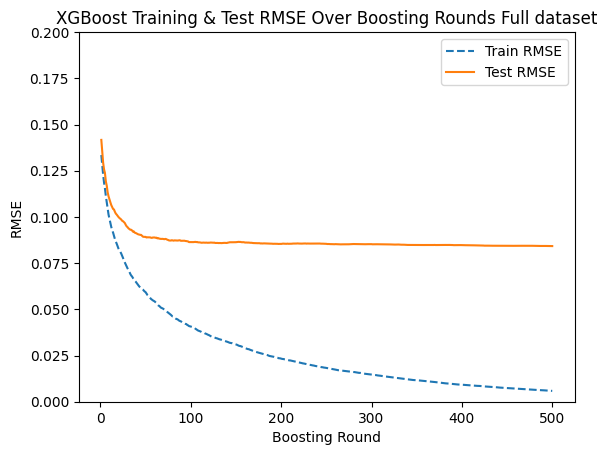

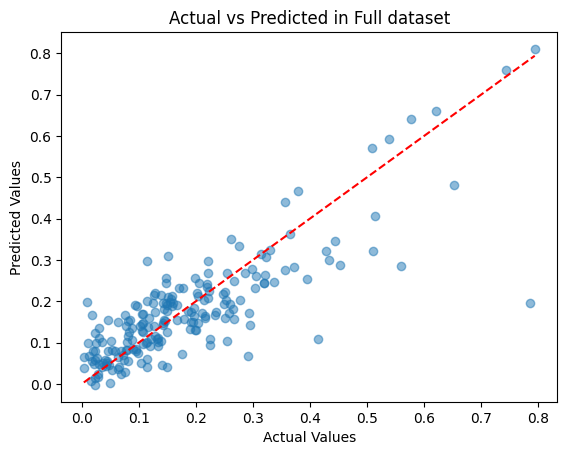

In [65]:
# #predict for the whole dataset (without rows having missing values on Grain.As)

dataname = "Full dataset"

model1 , evals_result , test_X , test_y = training(cleaned_dataset , params , num_boost_round )

plot_training_curve(evals_result , dataname)

plot_prediction(model1 , test_X , test_y , dataname)

# Split the whole data set into different datasets for different crops

I suspect that the techniques to grow fields is different between crops, which can affects on the quality and chemical accumulation in grain/straw/soil. 
So I split dataset into: Winter-Spring season and Summer-Autumn season. This technique will further decrease RMSE on Asen cummulation prediction.

In [66]:
print(cleaned_dataset[cleaned_dataset['Season.planted'] == 'Winter-Spring season']['Grain.As'].mean() , cleaned_dataset[cleaned_dataset['Season.planted'] == 'Winter-Spring season']['Grain.As'].var() )
print(cleaned_dataset[cleaned_dataset['Season.planted'] == 'Summer-Autumn season']['Grain.As'].mean() , cleaned_dataset[cleaned_dataset['Season.planted'] == 'Summer-Autumn season']['Grain.As'].var())
WS_data = cleaned_dataset[cleaned_dataset['Season.planted'] == 'Winter-Spring season']

SA_data = cleaned_dataset[cleaned_dataset['Season.planted'] == 'Summer-Autumn season']

print(len(WS_data) , len(SA_data))

0.1532057502569244 0.009963997971955251
0.2143124887974399 0.041588421344006095
468 201


# Predict with Winter spring crops 

[0]	train-rmse:0.09192	test-rmse:0.10793
[1]	train-rmse:0.08900	test-rmse:0.10604
[2]	train-rmse:0.08627	test-rmse:0.10550
[3]	train-rmse:0.08402	test-rmse:0.10372
[4]	train-rmse:0.08176	test-rmse:0.10274
[5]	train-rmse:0.07969	test-rmse:0.10143
[6]	train-rmse:0.07798	test-rmse:0.10049
[7]	train-rmse:0.07621	test-rmse:0.09940
[8]	train-rmse:0.07468	test-rmse:0.09855
[9]	train-rmse:0.07284	test-rmse:0.09807
[10]	train-rmse:0.07141	test-rmse:0.09706
[11]	train-rmse:0.06985	test-rmse:0.09632
[12]	train-rmse:0.06862	test-rmse:0.09610
[13]	train-rmse:0.06729	test-rmse:0.09535
[14]	train-rmse:0.06580	test-rmse:0.09438
[15]	train-rmse:0.06461	test-rmse:0.09344
[16]	train-rmse:0.06377	test-rmse:0.09334
[17]	train-rmse:0.06260	test-rmse:0.09299
[18]	train-rmse:0.06162	test-rmse:0.09234
[19]	train-rmse:0.06049	test-rmse:0.09109
[20]	train-rmse:0.05949	test-rmse:0.09077
[21]	train-rmse:0.05874	test-rmse:0.09055
[22]	train-rmse:0.05768	test-rmse:0.08977
[23]	train-rmse:0.05673	test-rmse:0.08954
[2

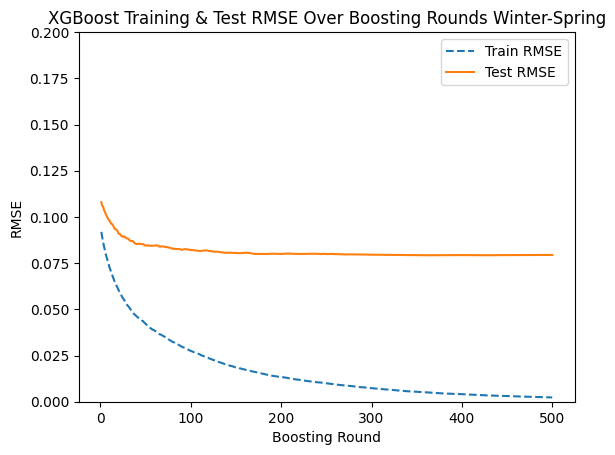

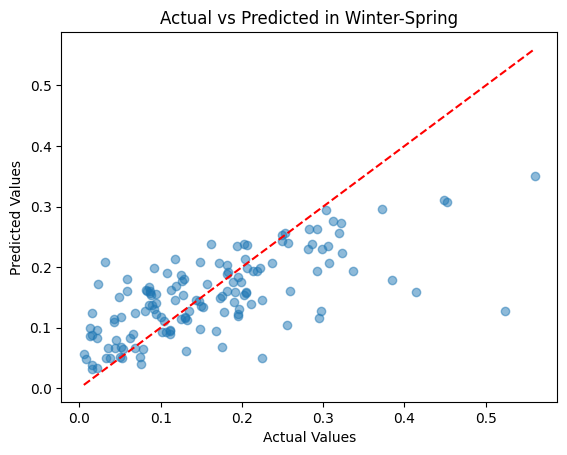

In [67]:
# #predicting for winter spring crops

dataname = "Winter-Spring"

model1 , evals_result , test_X , test_y = training(WS_data , params , num_boost_round )

plot_training_curve(evals_result , dataname)

plot_prediction(model1 , test_X , test_y ,  dataname)


# Predict for summer-autumn crops

[0]	train-rmse:0.19493	test-rmse:0.17753
[1]	train-rmse:0.18235	test-rmse:0.16784
[2]	train-rmse:0.17128	test-rmse:0.16022


[3]	train-rmse:0.16045	test-rmse:0.14887
[4]	train-rmse:0.15022	test-rmse:0.14082
[5]	train-rmse:0.14098	test-rmse:0.13418
[6]	train-rmse:0.13304	test-rmse:0.12844
[7]	train-rmse:0.12599	test-rmse:0.12230
[8]	train-rmse:0.11936	test-rmse:0.11474
[9]	train-rmse:0.11397	test-rmse:0.11041
[10]	train-rmse:0.10963	test-rmse:0.10871
[11]	train-rmse:0.10411	test-rmse:0.10671
[12]	train-rmse:0.09913	test-rmse:0.10403
[13]	train-rmse:0.09480	test-rmse:0.10108
[14]	train-rmse:0.09131	test-rmse:0.09951
[15]	train-rmse:0.08752	test-rmse:0.09891
[16]	train-rmse:0.08408	test-rmse:0.09629
[17]	train-rmse:0.08099	test-rmse:0.09438
[18]	train-rmse:0.07785	test-rmse:0.09196
[19]	train-rmse:0.07576	test-rmse:0.09139
[20]	train-rmse:0.07403	test-rmse:0.09012
[21]	train-rmse:0.07220	test-rmse:0.09003
[22]	train-rmse:0.07050	test-rmse:0.08944
[23]	train-rmse:0.06830	test-rmse:0.08855
[24]	train-rmse:0.06605	test-rmse:0.08758
[25]	train-rmse:0.06484	test-rmse:0.08706
[26]	train-rmse:0.06262	test-rmse:0.08621

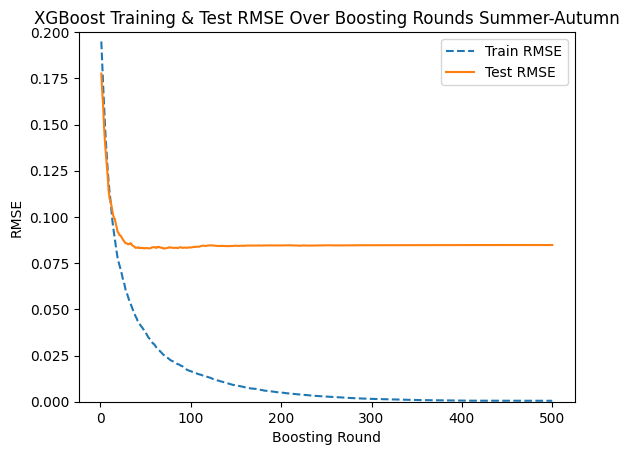

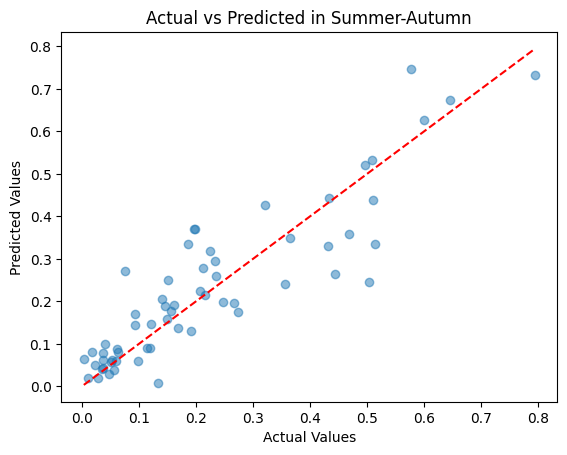

In [68]:
# #predicting for summer_autumn crops

dataname = "Summer-Autumn"

model1 , evals_result , test_X , test_y = training(SA_data , params , num_boost_round )

plot_training_curve(evals_result , dataname)

plot_prediction(model1 , test_X , test_y , dataname)




In [69]:
cleaned_dataset.iloc[:5 , :16]

,Sample.code,Lattitude,Longitude,Season.planted,Grain.As,Grain.P,Grain.S,Grain.Mn,Grain.Fe,Grain.Cu,Straw.As,Straw.Al,Straw.P,Straw.S,Straw.Mn,Straw.Fe
0,23Vin1_#1,10.105651,105.894707,Winter-Spring season,0.523334,2984.341641,1092.869532,22.782137,28.896448,2.074383,0.616872,627.615923,1151.179218,1612.474281,801.542633,401.254888
1,23Vin2_#1,10.071678,105.927982,Winter-Spring season,0.312485,3127.027761,1131.268467,19.842637,1.784861,2.024729,0.707296,249.273175,1136.949392,1376.276784,797.197832,217.919123
2,23Vin3_#1,10.073358,105.992213,Winter-Spring season,0.058160,3195.274467,991.132283,17.984741,41.951877,1.626614,0.526424,203.703811,1256.785962,1162.890087,263.397595,271.415308
3,23Vin4_#1,10.142449,106.021702,Winter-Spring season,0.037008,2682.304757,855.024208,16.678840,1.100623,1.760309,0.489382,382.900847,2626.530750,2375.451115,864.473531,356.117865
4,23Vin5_#1,10.075267,106.170488,Winter-Spring season,0.170522,2963.072168,810.699618,15.986882,3.180604,0.975245,4.031916,533.999448,1954.781134,738.888980,636.466670,493.523147


# Using location (lattitude and longtitude) for predicting Arsenic accumulation 

Because different areas have different climates, so farmer have to choose types of tree to grow. Different types of tree have different abilities of chemical accumulation 

### below experiment is taken earlier  


In [70]:
# #predict for the whole dataset (without rows having missing values on Grain.As)



In [71]:
# #predict for the whole dataset (without rows having missing values on Grain.As)


In [72]:
for i in range(len(cleaned_dataset.columns)):
    print(i , cleaned_dataset.columns[i])

0 Sample.code
1 Lattitude 
2 Longitude
3 Season.planted
4 Grain.As
5 Grain.P
6 Grain.S
7 Grain.Mn
8 Grain.Fe
9 Grain.Cu
10 Straw.As
11 Straw.Al
12 Straw.P
13 Straw.S
14 Straw.Mn
15 Straw.Fe
16 Soil.As
17 Soil.Al
18 Soil.P
19 Soil.S
20 Soil.Mn
21 Soil.Fe
22 Soil.pH
23 Soil.Clay
24 Soil.SOM
25 Temperature
26 Rainfall
27 Humidity
28 Potential.Evaporation


### below is experiment not using location

In [73]:
# #predict for the whole dataset (without rows having missing values on Grain.As)






In [74]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

### below are encoding Season to a feature and then use it for XGboost in full dataset

### below are experiment only using high correlated values with Grain Asen

In [75]:
# #predict for the whole dataset (without rows having missing values on Grain.As)


# Using KFold to evaluate as if location is truely neccessary 

Training fold 1/6
[0]	train-rmse:0.13283	test-rmse:0.14840
[1]	train-rmse:0.12773	test-rmse:0.14389
[2]	train-rmse:0.12281	test-rmse:0.14006
[3]	train-rmse:0.11910	test-rmse:0.13709
[4]	train-rmse:0.11457	test-rmse:0.13272
[5]	train-rmse:0.11096	test-rmse:0.12845
[6]	train-rmse:0.10839	test-rmse:0.12564
[7]	train-rmse:0.10520	test-rmse:0.12314
[8]	train-rmse:0.10210	test-rmse:0.12067
[9]	train-rmse:0.09927	test-rmse:0.11851
[10]	train-rmse:0.09701	test-rmse:0.11647
[11]	train-rmse:0.09537	test-rmse:0.11578
[12]	train-rmse:0.09349	test-rmse:0.11427
[13]	train-rmse:0.09155	test-rmse:0.11263
[14]	train-rmse:0.08994	test-rmse:0.11177
[15]	train-rmse:0.08869	test-rmse:0.11165
[16]	train-rmse:0.08717	test-rmse:0.11108
[17]	train-rmse:0.08596	test-rmse:0.11034
[18]	train-rmse:0.08499	test-rmse:0.10999
[19]	train-rmse:0.08343	test-rmse:0.10956
[20]	train-rmse:0.08224	test-rmse:0.10892
[21]	train-rmse:0.08148	test-rmse:0.10886
[22]	train-rmse:0.08039	test-rmse:0.10860
[23]	train-rmse:0.07930	te

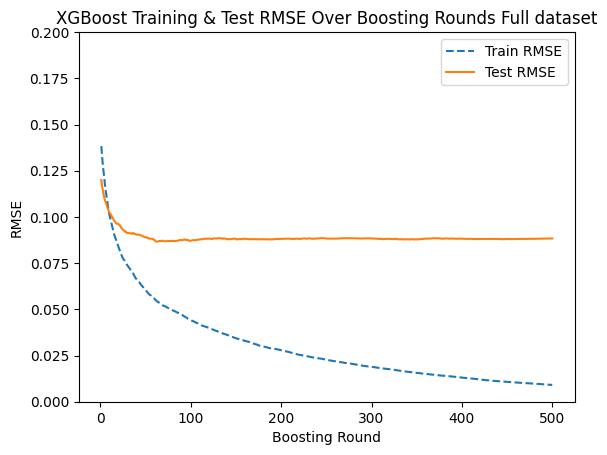

Fold 6 RMSE: 0.0866

Training fold 1/6
[0]	train-rmse:0.13410	test-rmse:0.14796
[1]	train-rmse:0.12812	test-rmse:0.14166
[2]	train-rmse:0.12396	test-rmse:0.13853
[3]	train-rmse:0.11933	test-rmse:0.13465
[4]	train-rmse:0.11507	test-rmse:0.13067
[5]	train-rmse:0.11090	test-rmse:0.12738
[6]	train-rmse:0.10771	test-rmse:0.12453
[7]	train-rmse:0.10453	test-rmse:0.12259
[8]	train-rmse:0.10169	test-rmse:0.11973
[9]	train-rmse:0.09942	test-rmse:0.11789
[10]	train-rmse:0.09754	test-rmse:0.11692
[11]	train-rmse:0.09559	test-rmse:0.11614
[12]	train-rmse:0.09384	test-rmse:0.11500
[13]	train-rmse:0.09185	test-rmse:0.11274
[14]	train-rmse:0.09058	test-rmse:0.11234
[15]	train-rmse:0.08914	test-rmse:0.11179
[16]	train-rmse:0.08766	test-rmse:0.11088
[17]	train-rmse:0.08631	test-rmse:0.11031
[18]	train-rmse:0.08486	test-rmse:0.10922
[19]	train-rmse:0.08392	test-rmse:0.10908
[20]	train-rmse:0.08275	test-rmse:0.10878
[21]	train-rmse:0.08201	test-rmse:0.10791
[22]	train-rmse:0.08057	test-rmse:0.10750
[23]	

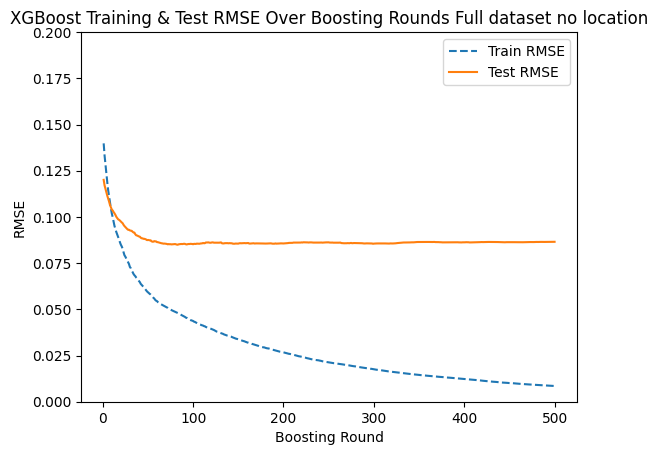

Fold 6 RMSE: 0.0850



In [78]:
# For full dataset 

test_rmse_with_location = run_kfold(params , cleaned_dataset , "Full dataset" , location=True , cv=6, plot_result= True)

test_rmse_without_location = run_kfold(params , cleaned_dataset , "Full dataset no location" , location=False , cv = 6, plot_result= True)





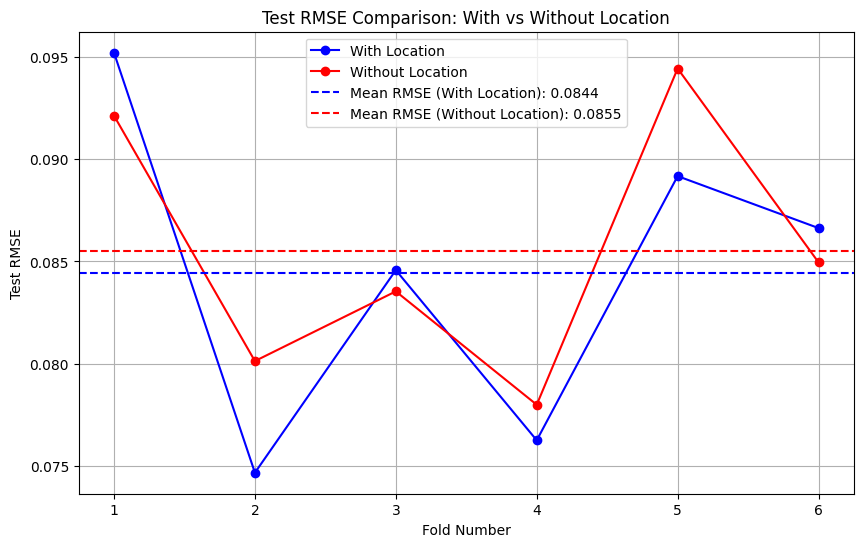

In [79]:




# Number of folds
num_folds = len(test_rmse_with_location)

# Create x-axis values (fold numbers)
folds = np.arange(1, num_folds + 1)

# Calculate mean RMSE for both scenarios
mean_rmse_with_location = np.mean(test_rmse_with_location)
mean_rmse_without_location = np.mean(test_rmse_without_location)

# Plotting
plt.figure(figsize=(10, 6))

# Plot RMSE for each fold
plt.plot(folds, test_rmse_with_location, marker='o', label='With Location', color='blue')
plt.plot(folds, test_rmse_without_location, marker='o', label='Without Location', color='red')

# Plot mean RMSE lines
plt.axhline(mean_rmse_with_location, color='blue', linestyle='--', label=f'Mean RMSE (With Location): {mean_rmse_with_location:.4f}')
plt.axhline(mean_rmse_without_location, color='red', linestyle='--', label=f'Mean RMSE (Without Location): {mean_rmse_without_location:.4f}')

# Add labels and title
plt.xlabel('Fold Number')
plt.ylabel('Test RMSE')
plt.title('Test RMSE Comparison: With vs Without Location')
plt.xticks(folds)  # Ensure x-axis shows fold numbers
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [80]:
def run_multiple_kfold(params , max_depth =True , eta = False , Subsample = False , Colsample = False):
    tmp_params = params
    result = pd.DataFrame()
    if max_depth:
        for i in range(3,10):
            tmp_params['max_depth'] = i
            test_rmse = run_kfold(tmp_params , cleaned_dataset, dataname="Full data" , location = True , plot_result= True)
            result[f'depth_{i}'] = test_rmse

    return result 

Training fold 1/5
[0]	train-rmse:0.13335	test-rmse:0.14436
[1]	train-rmse:0.12781	test-rmse:0.13873
[2]	train-rmse:0.12262	test-rmse:0.13278
[3]	train-rmse:0.11875	test-rmse:0.12892
[4]	train-rmse:0.11436	test-rmse:0.12506
[5]	train-rmse:0.11024	test-rmse:0.12151
[6]	train-rmse:0.10710	test-rmse:0.11954
[7]	train-rmse:0.10384	test-rmse:0.11725
[8]	train-rmse:0.10074	test-rmse:0.11553
[9]	train-rmse:0.09813	test-rmse:0.11387
[10]	train-rmse:0.09576	test-rmse:0.11260
[11]	train-rmse:0.09370	test-rmse:0.11151
[12]	train-rmse:0.09217	test-rmse:0.11104
[13]	train-rmse:0.09058	test-rmse:0.11037
[14]	train-rmse:0.08918	test-rmse:0.11001
[15]	train-rmse:0.08792	test-rmse:0.10962
[16]	train-rmse:0.08666	test-rmse:0.10900
[17]	train-rmse:0.08530	test-rmse:0.10798
[18]	train-rmse:0.08392	test-rmse:0.10787
[19]	train-rmse:0.08265	test-rmse:0.10750
[20]	train-rmse:0.08151	test-rmse:0.10735
[21]	train-rmse:0.08083	test-rmse:0.10771
[22]	train-rmse:0.08010	test-rmse:0.10788
[23]	train-rmse:0.07884	te

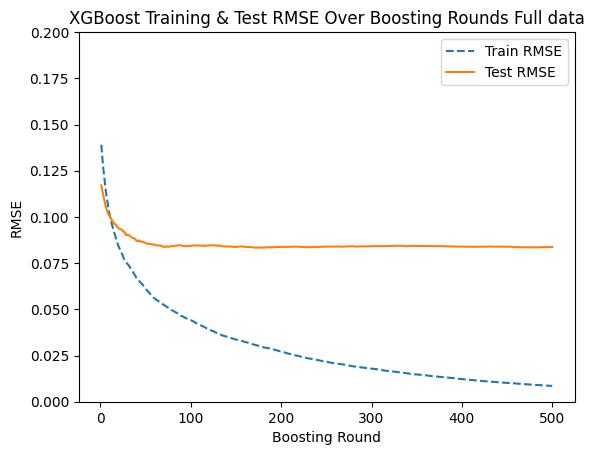

Fold 5 RMSE: 0.0833

Training fold 1/5
[0]	train-rmse:0.13279	test-rmse:0.14408
[1]	train-rmse:0.12659	test-rmse:0.13802
[2]	train-rmse:0.12067	test-rmse:0.13210
[3]	train-rmse:0.11597	test-rmse:0.12772
[4]	train-rmse:0.11098	test-rmse:0.12330
[5]	train-rmse:0.10622	test-rmse:0.11933
[6]	train-rmse:0.10246	test-rmse:0.11683
[7]	train-rmse:0.09856	test-rmse:0.11424
[8]	train-rmse:0.09541	test-rmse:0.11252
[9]	train-rmse:0.09241	test-rmse:0.11074
[10]	train-rmse:0.08970	test-rmse:0.10912
[11]	train-rmse:0.08704	test-rmse:0.10779
[12]	train-rmse:0.08498	test-rmse:0.10684
[13]	train-rmse:0.08314	test-rmse:0.10597
[14]	train-rmse:0.08112	test-rmse:0.10524
[15]	train-rmse:0.07967	test-rmse:0.10503
[16]	train-rmse:0.07786	test-rmse:0.10403
[17]	train-rmse:0.07628	test-rmse:0.10341
[18]	train-rmse:0.07471	test-rmse:0.10210
[19]	train-rmse:0.07314	test-rmse:0.10175
[20]	train-rmse:0.07177	test-rmse:0.10156
[21]	train-rmse:0.07050	test-rmse:0.10153
[22]	train-rmse:0.06954	test-rmse:0.10144
[23]	

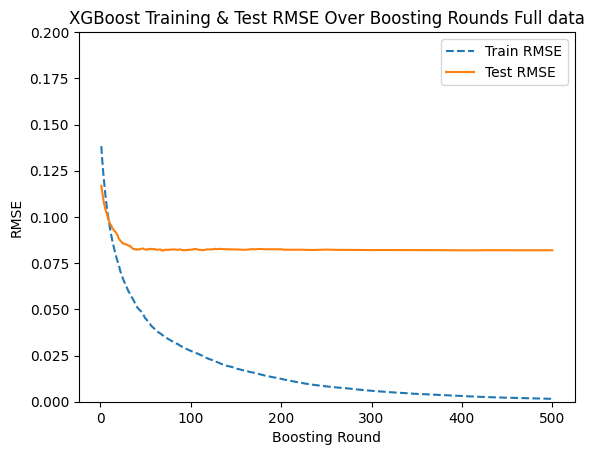

Fold 5 RMSE: 0.0818

Training fold 1/5
[0]	train-rmse:0.13222	test-rmse:0.14381
[1]	train-rmse:0.12524	test-rmse:0.13689
[2]	train-rmse:0.11860	test-rmse:0.13054
[3]	train-rmse:0.11332	test-rmse:0.12620
[4]	train-rmse:0.10781	test-rmse:0.12183
[5]	train-rmse:0.10243	test-rmse:0.11776
[6]	train-rmse:0.09804	test-rmse:0.11464
[7]	train-rmse:0.09361	test-rmse:0.11177
[8]	train-rmse:0.09013	test-rmse:0.10988
[9]	train-rmse:0.08643	test-rmse:0.10787
[10]	train-rmse:0.08309	test-rmse:0.10590
[11]	train-rmse:0.07966	test-rmse:0.10457
[12]	train-rmse:0.07710	test-rmse:0.10382
[13]	train-rmse:0.07493	test-rmse:0.10273
[14]	train-rmse:0.07246	test-rmse:0.10210
[15]	train-rmse:0.07065	test-rmse:0.10173
[16]	train-rmse:0.06849	test-rmse:0.10089
[17]	train-rmse:0.06636	test-rmse:0.10026
[18]	train-rmse:0.06500	test-rmse:0.09956
[19]	train-rmse:0.06289	test-rmse:0.09900
[20]	train-rmse:0.06080	test-rmse:0.09822
[21]	train-rmse:0.05939	test-rmse:0.09795
[22]	train-rmse:0.05846	test-rmse:0.09816
[23]	

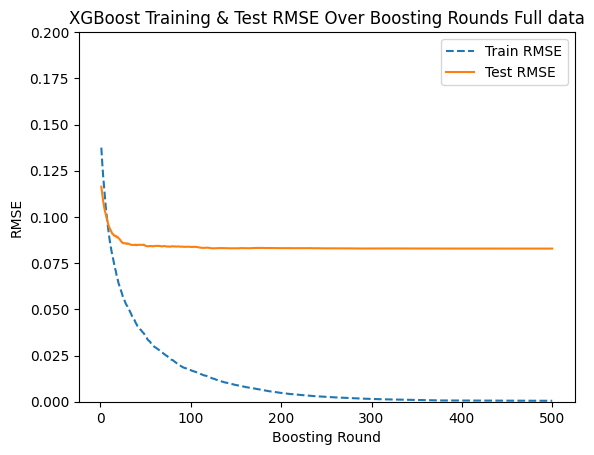

Fold 5 RMSE: 0.0829

Training fold 1/5
[0]	train-rmse:0.13181	test-rmse:0.14424
[1]	train-rmse:0.12394	test-rmse:0.13685
[2]	train-rmse:0.11680	test-rmse:0.13013
[3]	train-rmse:0.11081	test-rmse:0.12611
[4]	train-rmse:0.10434	test-rmse:0.12062
[5]	train-rmse:0.09885	test-rmse:0.11633
[6]	train-rmse:0.09409	test-rmse:0.11347
[7]	train-rmse:0.08917	test-rmse:0.11036
[8]	train-rmse:0.08534	test-rmse:0.10844
[9]	train-rmse:0.08139	test-rmse:0.10642
[10]	train-rmse:0.07750	test-rmse:0.10510
[11]	train-rmse:0.07400	test-rmse:0.10353
[12]	train-rmse:0.07103	test-rmse:0.10257
[13]	train-rmse:0.06835	test-rmse:0.10116
[14]	train-rmse:0.06593	test-rmse:0.10075
[15]	train-rmse:0.06386	test-rmse:0.09997
[16]	train-rmse:0.06134	test-rmse:0.09925
[17]	train-rmse:0.05930	test-rmse:0.09844
[18]	train-rmse:0.05763	test-rmse:0.09789
[19]	train-rmse:0.05614	test-rmse:0.09761
[20]	train-rmse:0.05444	test-rmse:0.09717
[21]	train-rmse:0.05344	test-rmse:0.09718
[22]	train-rmse:0.05190	test-rmse:0.09684
[23]	

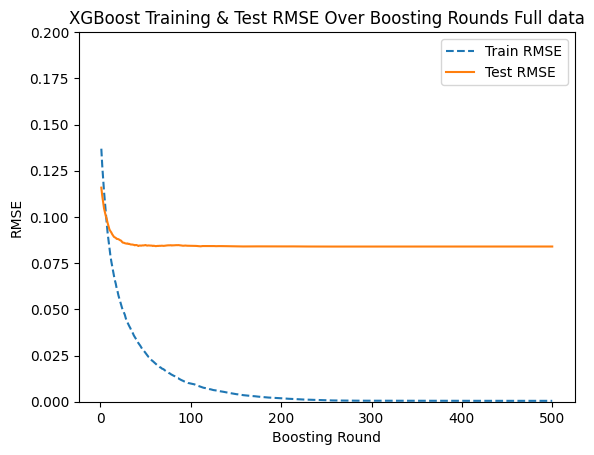

Fold 5 RMSE: 0.0840

Training fold 1/5
[0]	train-rmse:0.13146	test-rmse:0.14380
[1]	train-rmse:0.12337	test-rmse:0.13593
[2]	train-rmse:0.11572	test-rmse:0.12947
[3]	train-rmse:0.10926	test-rmse:0.12522
[4]	train-rmse:0.10244	test-rmse:0.11987
[5]	train-rmse:0.09634	test-rmse:0.11554
[6]	train-rmse:0.09111	test-rmse:0.11219
[7]	train-rmse:0.08594	test-rmse:0.10913
[8]	train-rmse:0.08156	test-rmse:0.10694
[9]	train-rmse:0.07737	test-rmse:0.10498
[10]	train-rmse:0.07301	test-rmse:0.10331
[11]	train-rmse:0.06923	test-rmse:0.10172
[12]	train-rmse:0.06615	test-rmse:0.10048
[13]	train-rmse:0.06317	test-rmse:0.09869
[14]	train-rmse:0.06017	test-rmse:0.09792
[15]	train-rmse:0.05784	test-rmse:0.09744
[16]	train-rmse:0.05537	test-rmse:0.09716
[17]	train-rmse:0.05349	test-rmse:0.09647
[18]	train-rmse:0.05114	test-rmse:0.09602
[19]	train-rmse:0.04930	test-rmse:0.09527
[20]	train-rmse:0.04686	test-rmse:0.09474
[21]	train-rmse:0.04573	test-rmse:0.09483
[22]	train-rmse:0.04444	test-rmse:0.09438
[23]	

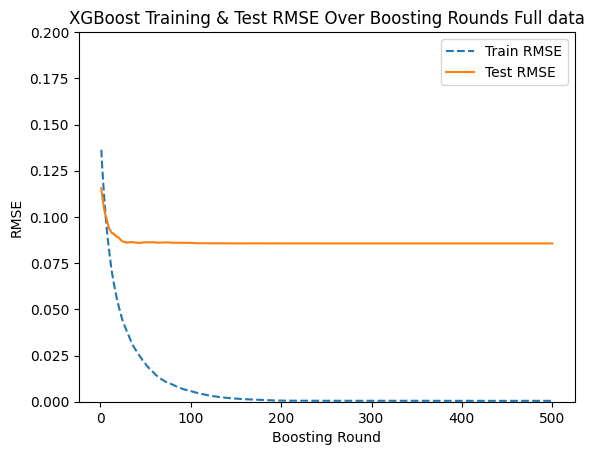

Fold 5 RMSE: 0.0857

Training fold 1/5
[0]	train-rmse:0.13125	test-rmse:0.14358
[1]	train-rmse:0.12252	test-rmse:0.13574
[2]	train-rmse:0.11457	test-rmse:0.12892
[3]	train-rmse:0.10775	test-rmse:0.12462
[4]	train-rmse:0.10037	test-rmse:0.11904
[5]	train-rmse:0.09398	test-rmse:0.11468
[6]	train-rmse:0.08844	test-rmse:0.11170
[7]	train-rmse:0.08291	test-rmse:0.10866
[8]	train-rmse:0.07828	test-rmse:0.10618
[9]	train-rmse:0.07381	test-rmse:0.10420
[10]	train-rmse:0.06917	test-rmse:0.10212
[11]	train-rmse:0.06507	test-rmse:0.09977
[12]	train-rmse:0.06200	test-rmse:0.09846
[13]	train-rmse:0.05893	test-rmse:0.09703
[14]	train-rmse:0.05571	test-rmse:0.09575
[15]	train-rmse:0.05303	test-rmse:0.09541
[16]	train-rmse:0.05042	test-rmse:0.09459
[17]	train-rmse:0.04819	test-rmse:0.09389
[18]	train-rmse:0.04595	test-rmse:0.09349
[19]	train-rmse:0.04405	test-rmse:0.09291
[20]	train-rmse:0.04210	test-rmse:0.09293
[21]	train-rmse:0.04067	test-rmse:0.09303
[22]	train-rmse:0.03870	test-rmse:0.09300
[23]	

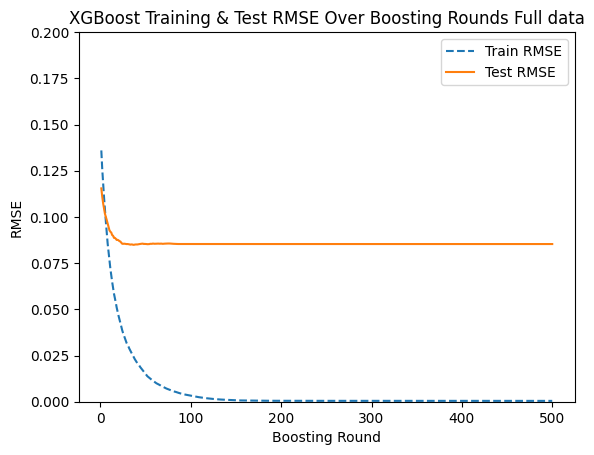

Fold 5 RMSE: 0.0849

Training fold 1/5
[0]	train-rmse:0.13098	test-rmse:0.14358
[1]	train-rmse:0.12210	test-rmse:0.13552
[2]	train-rmse:0.11385	test-rmse:0.12830
[3]	train-rmse:0.10689	test-rmse:0.12409
[4]	train-rmse:0.09911	test-rmse:0.11795
[5]	train-rmse:0.09234	test-rmse:0.11326
[6]	train-rmse:0.08645	test-rmse:0.11061
[7]	train-rmse:0.08091	test-rmse:0.10760
[8]	train-rmse:0.07613	test-rmse:0.10558
[9]	train-rmse:0.07129	test-rmse:0.10406
[10]	train-rmse:0.06648	test-rmse:0.10215
[11]	train-rmse:0.06261	test-rmse:0.10039
[12]	train-rmse:0.05983	test-rmse:0.09921
[13]	train-rmse:0.05692	test-rmse:0.09819
[14]	train-rmse:0.05361	test-rmse:0.09722
[15]	train-rmse:0.05055	test-rmse:0.09639
[16]	train-rmse:0.04799	test-rmse:0.09512
[17]	train-rmse:0.04571	test-rmse:0.09403
[18]	train-rmse:0.04335	test-rmse:0.09369
[19]	train-rmse:0.04120	test-rmse:0.09323
[20]	train-rmse:0.03914	test-rmse:0.09250
[21]	train-rmse:0.03743	test-rmse:0.09219
[22]	train-rmse:0.03602	test-rmse:0.09213
[23]	

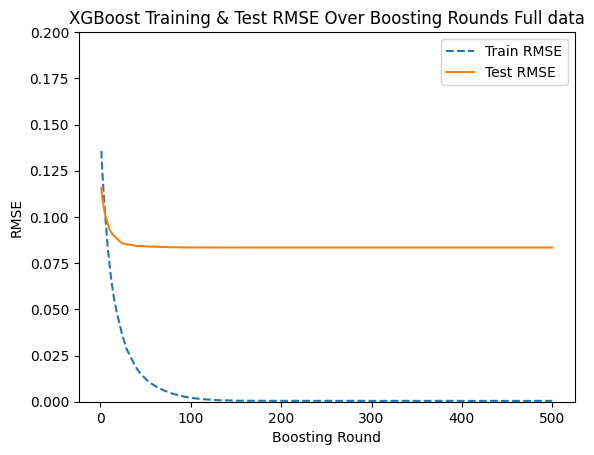

Fold 5 RMSE: 0.0834



In [81]:
result_finetune = run_multiple_kfold(params)

In [82]:
result_finetune

,depth_3,depth_4,depth_5,depth_6,depth_7,depth_8,depth_9
0,0.093246,0.090186,0.089031,0.090307,0.091075,0.090418,0.089321
1,0.088156,0.085734,0.090061,0.092831,0.093052,0.092968,0.092546
2,0.083428,0.084576,0.087232,0.088990,0.087632,0.087389,0.086567
3,0.099435,0.099233,0.095346,0.095352,0.094748,0.094471,0.096087
4,0.083322,0.081763,0.082861,0.083959,0.085653,0.084891,0.083420
